# Credit Card Approval Prediction

### Introduction

In this project, we are trying to predict whether a bank will approve or issue a credit card to a new customer. The target variable in the dataset is not explicitly defined, so we have decided to use the data where the customer delayed payment for more than 60 days as a proxy for default. This means that we are defining a defaulter as someone who is likely to have their credit card application rejected.

There is an imbalance data in the dataset, with more customers who are approved for credit cards than those who are not. To address this, we will use SMOTE (Synthetic Minority Oversampling Technique) after splitting the data into training and testing sets. This will help to ensure that the model is not biased towards the majority class (approved customers).

By taking these steps, we can build a more accurate model that can be used to predict whether a new customer will be approved for a credit card.

### About Dataset
Data link : https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

###### application_record.csv
This csv file contains information about individual loan or credit card applications.

ID : A unique identifier for each record or applicant.

CODE_GENDER : Gender of the applicant.

FLAG_OWN_CAR : Whether the applicant owns a car.

FLAG_OWN_REALTY : Whether the applicant owns real estate property.

CNT_CHILDREN : The number of children the applicant has.

AMT_INCOME_TOTAL : Total annual income of the applicant.

NAME_INCOME_TYPE : Type of income.

NAME_EDUCATION_TYPE : Education level of the applicant.

NAME_FAMILY_STATUS : Family status of the applicant.

DAYS_BIRTH : Age of the applicant in days.

DAYS_EMPLOYED : Number of days the applicant has been employed.

FLAG_MOBIL : Whether the applicant has a mobile phone.

###### credit_record.csv
This file typically contains information about an individual's credit history over time.

ID: A unique identifier linking to the corresponding application record.

MONTHS_BALANCE: A numeric indicator representing the month of the record (-1 for the previous month, -2 for the month before that).


STATUS: Credit status for that month.

0: No DPD (Days Past Due), meaning no overdue payments.

1: DPD 1-30 days, indicating payments were overdue by 1 to 30 days.

2: DPD 31-60 days, indicating payments were overdue by 31 to 60 days.

3: DPD 61-90 days, indicating payments were overdue by 61 to 90 days.

4: DPD 91+ days, indicating payments were overdue by more than 91 days.

5: Credit account associated with this entry has been closed.

C: No DPD, indicates that no delay in payment occurred.

X: No information about the credit status. 

### Imports And Installations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc



### Data Loading

In [2]:
application_data = pd.read_csv('application_record.csv')
credit_data = pd.read_csv('credit_record.csv')

### Visualization And Preprocessing

we want to turn our attention to credit_data to determine a system for what customers we want to approve for a credit card, what customers we want to deny, and what customers we want to omit.

Any customer who has an X for a status, indicating that they do not currently have a loan, will be omitted due to a lack of information about their credit history

Any customer who is less than 30 days overdue will be considered approved because they have demonstrated an ability to avoid excessive late payments

Any customer who is greater than 30 days overdue will be considered denied because they have demonstrated a lack of ability to pay on time

In [3]:
#we will mark omited customers with a -1, denied customers with a 0, and approved customers with a 1

def approval(df):
    if(df['STATUS'] == 'X'):
        return -1
    
    elif(df['STATUS'] == '1' or df['STATUS'] == '2' or df['STATUS'] == '3' or df['STATUS'] == '4' or df['STATUS'] == '5'):
        return 0
    
    elif(df['STATUS'] == 'C' or df['STATUS'] == '0'):
        return 1


In [4]:
#create an approved series in df_credit_record

credit_data['APPROVED_STATUS'] = credit_data.apply(approval, axis=1)

#remove those with an X as a status that we want to omit

credit_data = credit_data[credit_data['APPROVED_STATUS'] != -1]
credit_data['STATUS'].value_counts()

STATUS
C    442031
0    383120
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [5]:
credit_data.APPROVED_STATUS.value_counts()

APPROVED_STATUS
1    825151
0     14194
Name: count, dtype: int64

In [6]:
# target column is created now we need to merge both the dataset.

data = pd.merge(application_data,credit_data,on='ID',how ='inner')

CNT_FAM_MEMBERS columns data type is float, need to change the data type.

In [7]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631765 entries, 0 to 631764
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   631765 non-null  int64  
 1   CODE_GENDER          631765 non-null  object 
 2   FLAG_OWN_CAR         631765 non-null  object 
 3   FLAG_OWN_REALTY      631765 non-null  object 
 4   CNT_CHILDREN         631765 non-null  int64  
 5   AMT_INCOME_TOTAL     631765 non-null  float64
 6   NAME_INCOME_TYPE     631765 non-null  object 
 7   NAME_EDUCATION_TYPE  631765 non-null  object 
 8   NAME_FAMILY_STATUS   631765 non-null  object 
 9   NAME_HOUSING_TYPE    631765 non-null  object 
 10  DAYS_BIRTH           631765 non-null  int64  
 11  DAYS_EMPLOYED        631765 non-null  int64  
 12  FLAG_MOBIL           631765 non-null  int64  
 13  FLAG_WORK_PHONE      631765 non-null  int64  
 14  FLAG_PHONE           631765 non-null  int64  
 15  FLAG_EMAIL       

In [8]:
# changed data type float to int
data['CNT_FAM_MEMBERS'] = data['CNT_FAM_MEMBERS'].astype(int)

In [9]:
data.nunique()

ID                     33110
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         258
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              6960
DAYS_EMPLOYED           3566
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
OCCUPATION_TYPE           18
CNT_FAM_MEMBERS           10
MONTHS_BALANCE            61
STATUS                     7
APPROVED_STATUS            2
dtype: int64

In [10]:
# Deleting unnecessary features
# FLAG_MOBIL Column contains similar value so it will not contribute to the model
# columns such as gender, religion, ethnicity these attributes does not help in predicting approval status 

data.drop(columns=['ID','FLAG_MOBIL','CODE_GENDER','MONTHS_BALANCE','STATUS'], inplace=True)

# Changing column name for better understanding binary Y and N into 1 and zero

for column in data.columns:
    if 'FLAG' in column:
        data[column] = data[column].replace({'Y': 1, 'N': 0})
        new_column = column.replace('FLAG_', '')
        data.rename(columns={column: new_column}, inplace=True)
    elif 'NAME' in column:
        new_column_2 = column.replace('NAME_', '')
        data.rename(columns={column: new_column_2}, inplace=True)

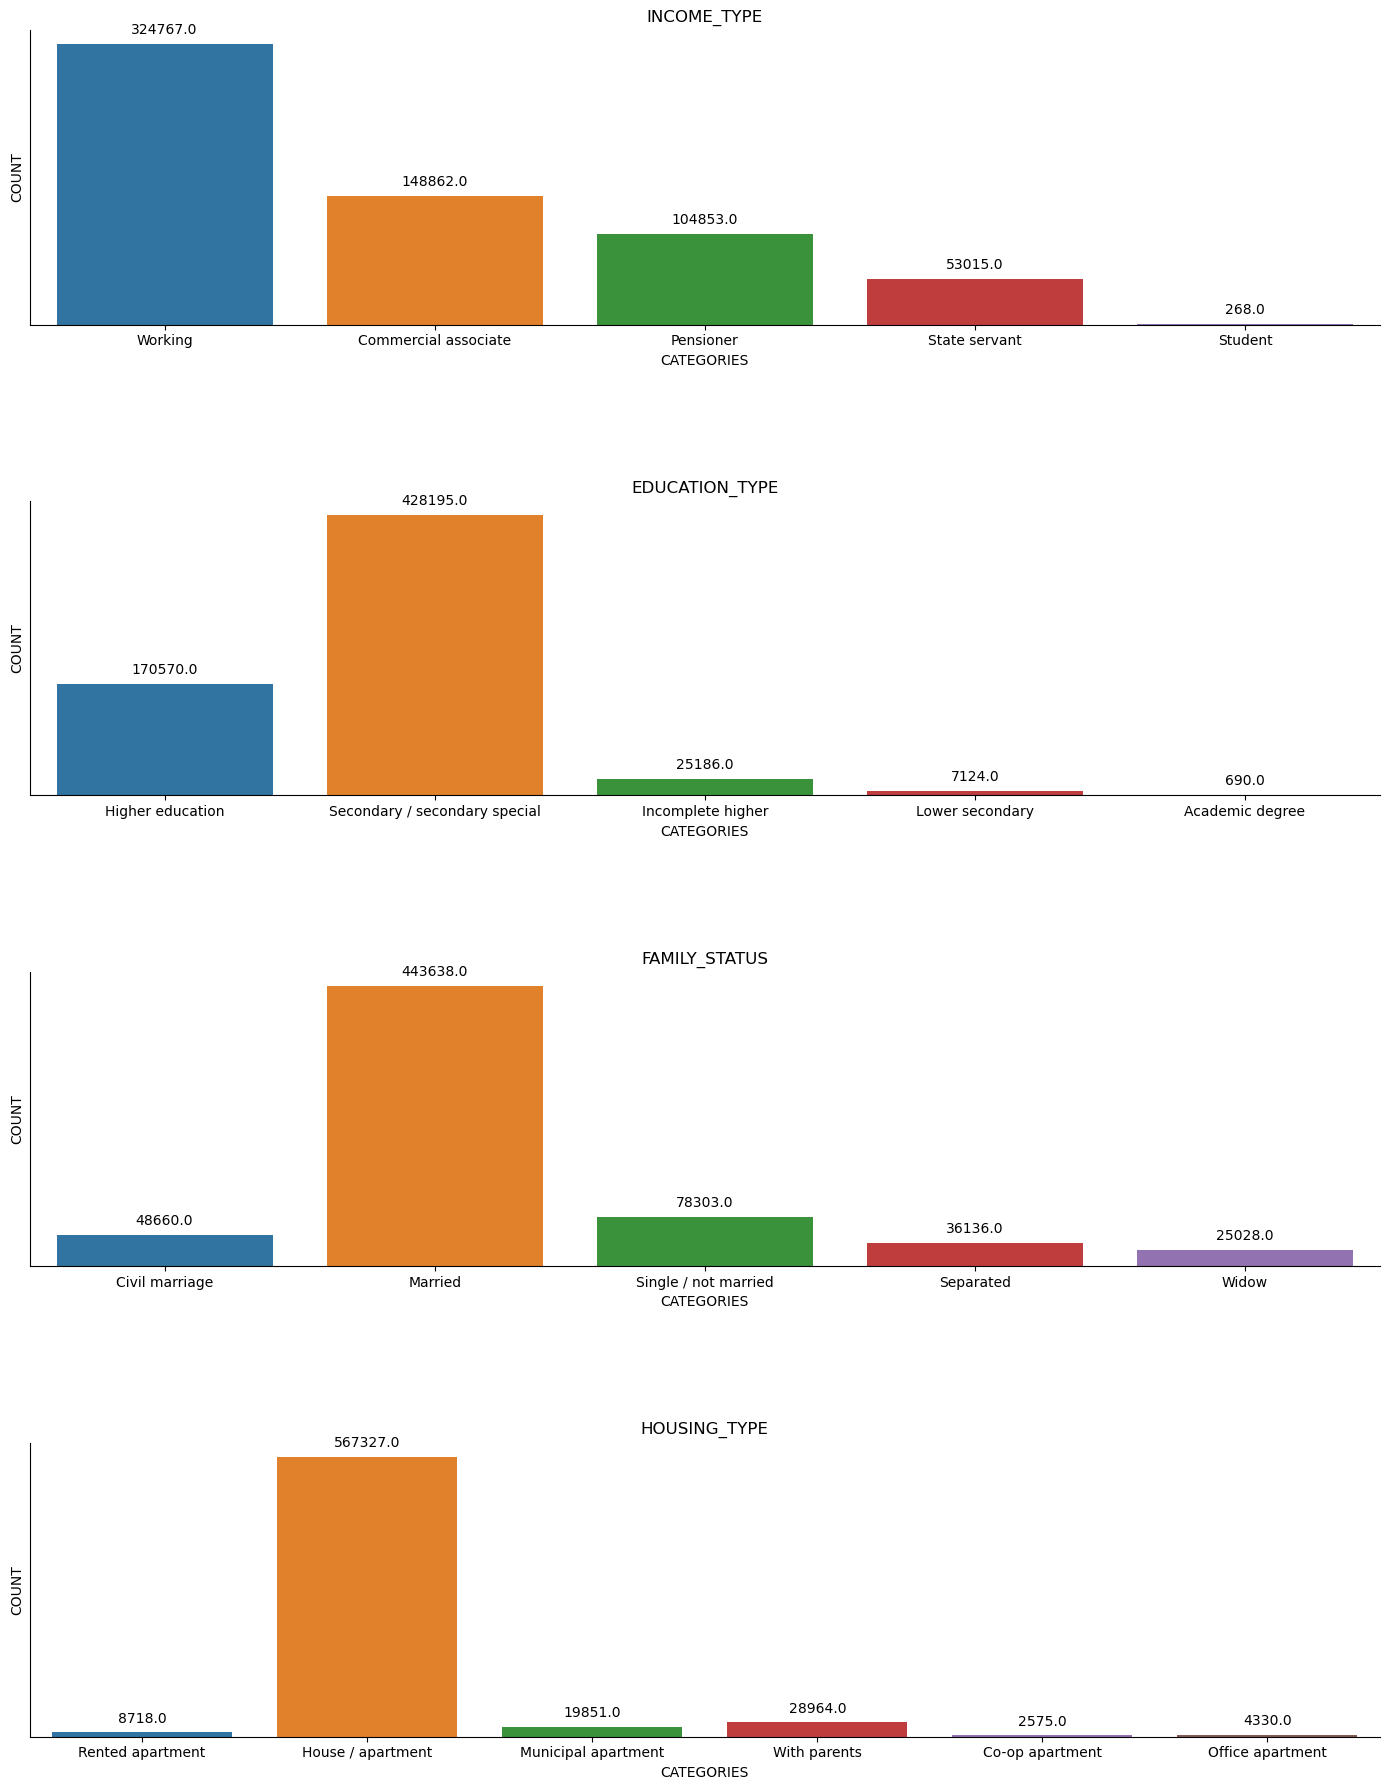

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 18))
columns_to_plot = ['INCOME_TYPE', 'EDUCATION_TYPE', 'FAMILY_STATUS', 'HOUSING_TYPE']

for i, column in enumerate(columns_to_plot):
    plt.subplot(4, 1, i+1)
    ax = sns.countplot(x=column, data=data)
    ax.set(yticklabels=[])
    plt.title(column)
    plt.xlabel('CATEGORIES')
    plt.ylabel('COUNT')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_yticks([])
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

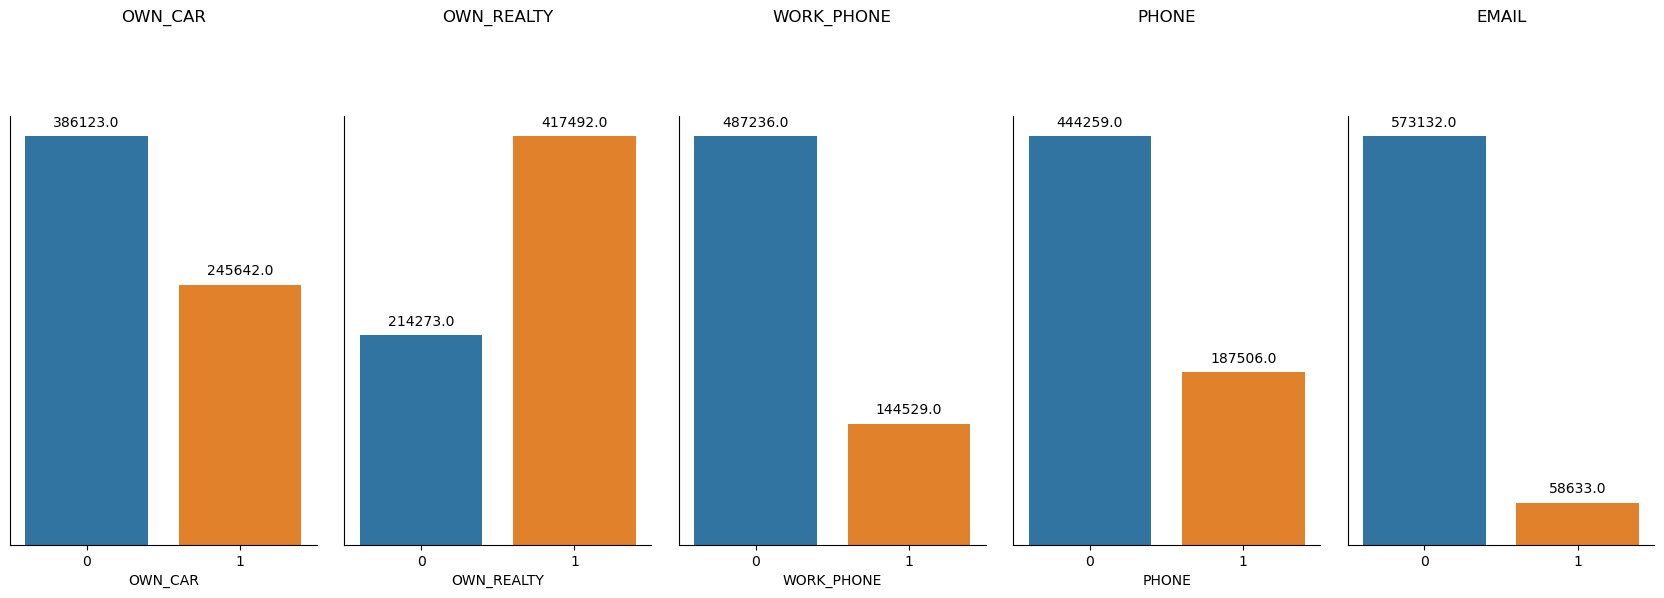

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(17,5))
columns_to_plot = ['OWN_CAR', 'OWN_REALTY', 'WORK_PHONE', 'PHONE', 'EMAIL']

for i, column in enumerate(columns_to_plot):
    value_counts = data[column].value_counts()
    ax = sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
    ax.set(yticklabels=[])
    axes[i].set_title(column, y=1.2)
    plt.xlabel('')
    plt.ylabel('')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_yticks([])
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
plt.tight_layout(pad = 2)
plt.subplots_adjust(hspace=0.6,top=1)
plt.show()

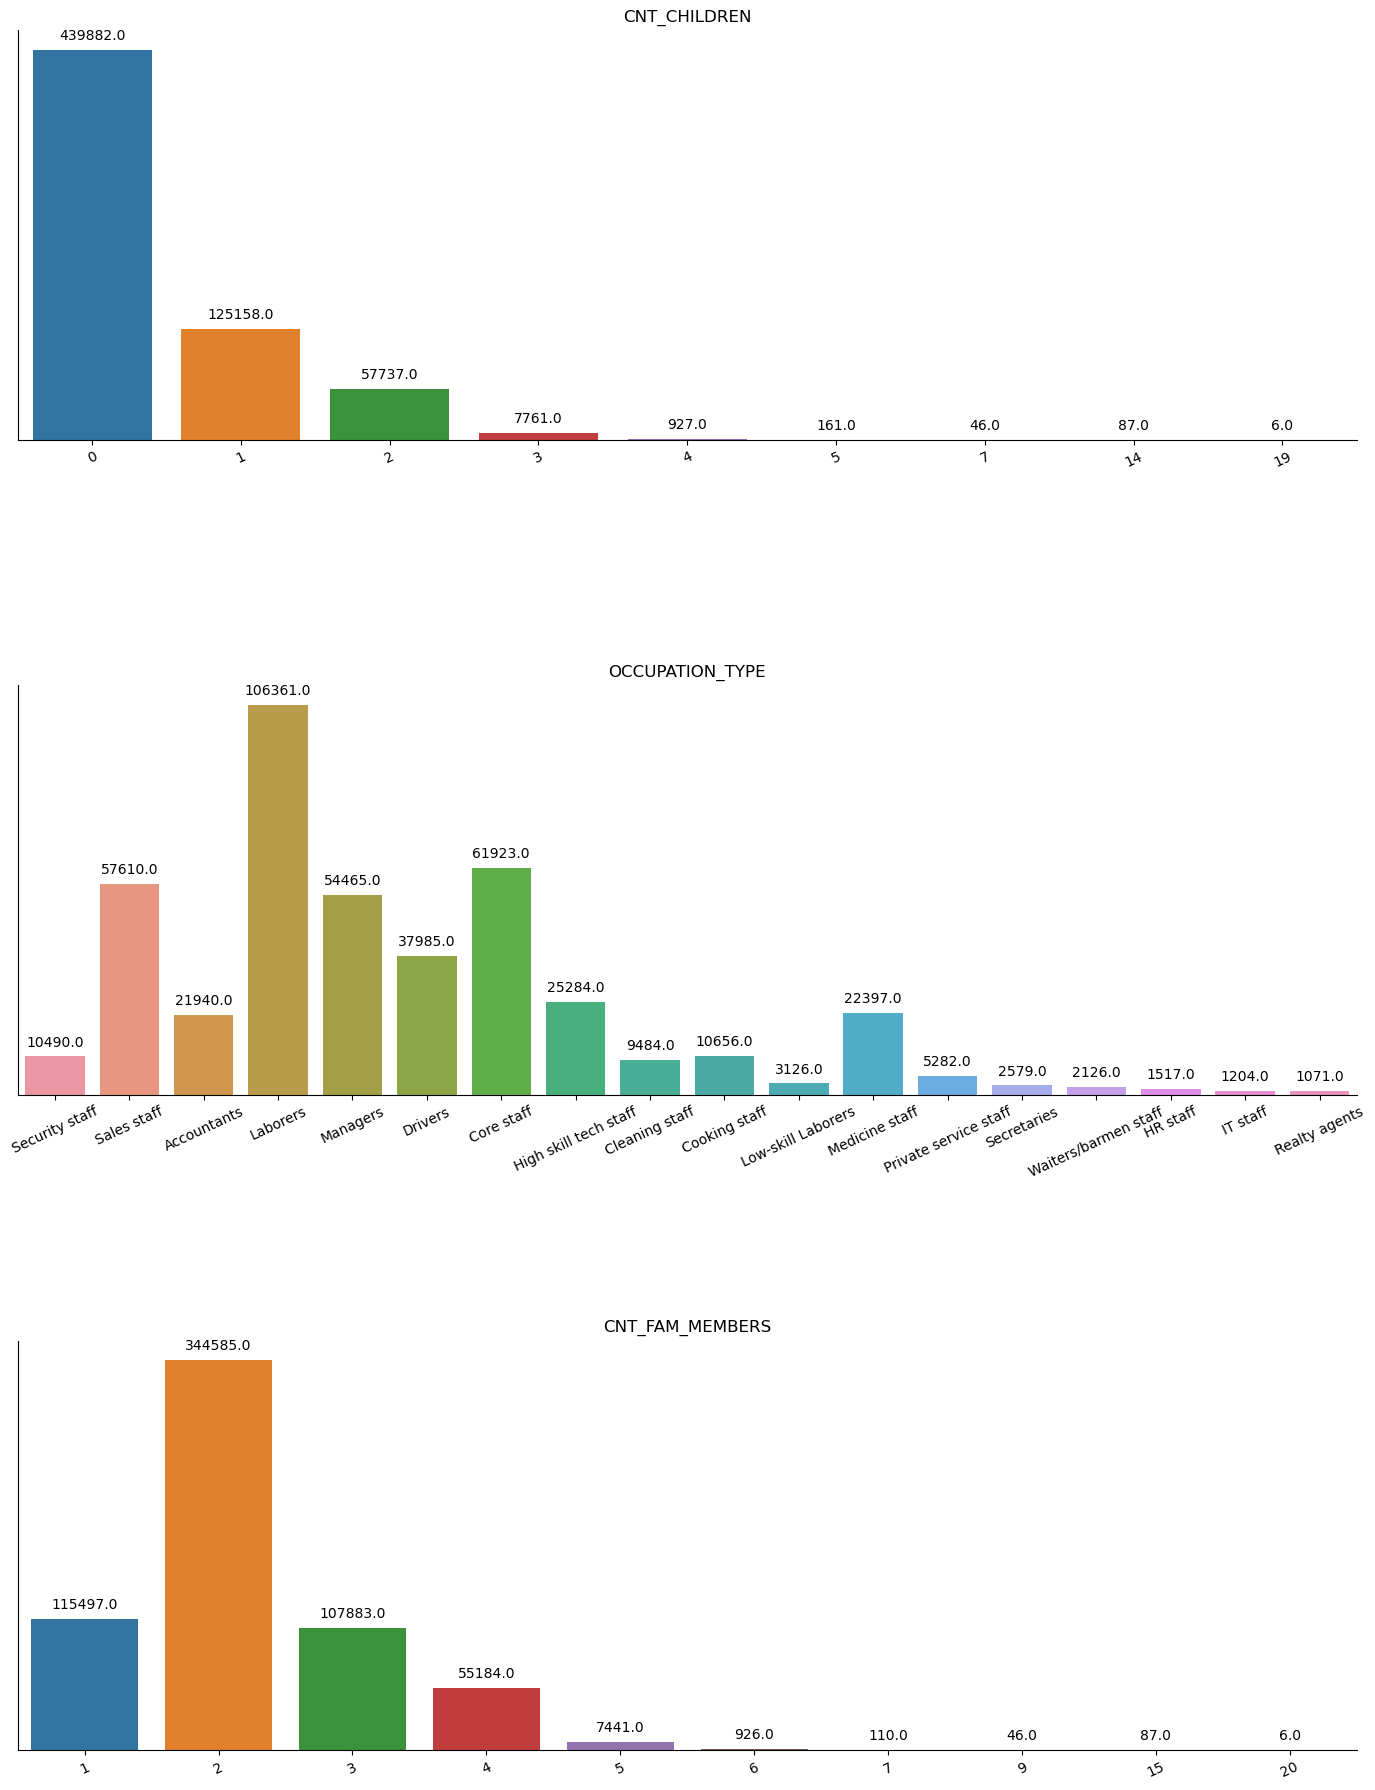

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 18))
columns_to_plot = ['CNT_CHILDREN', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 1, i+1)
    ax = sns.countplot(x=column, data=data)
    ax.set(yticklabels=[])
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=25)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_yticks([])
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

### Handling Missing Value

631765 rows and 19 columns are present in dataset, 
OCCUPATION_TYPE column contains 196265 null values that is 31% of the whole data.

If drop all null values we can loose mejority of data and model performance could be affected.
We need to predict actual values of null values, there are different methods for handling the null values,
We are going to use Decision tree classifier

In [14]:
data.isnull().sum() # Occupation type column contains 31 % null values of all data

OWN_CAR                  0
OWN_REALTY               0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
INCOME_TYPE              0
EDUCATION_TYPE           0
FAMILY_STATUS            0
HOUSING_TYPE             0
DAYS_BIRTH               0
DAYS_EMPLOYED            0
WORK_PHONE               0
PHONE                    0
EMAIL                    0
OCCUPATION_TYPE     196265
CNT_FAM_MEMBERS          0
APPROVED_STATUS          0
dtype: int64

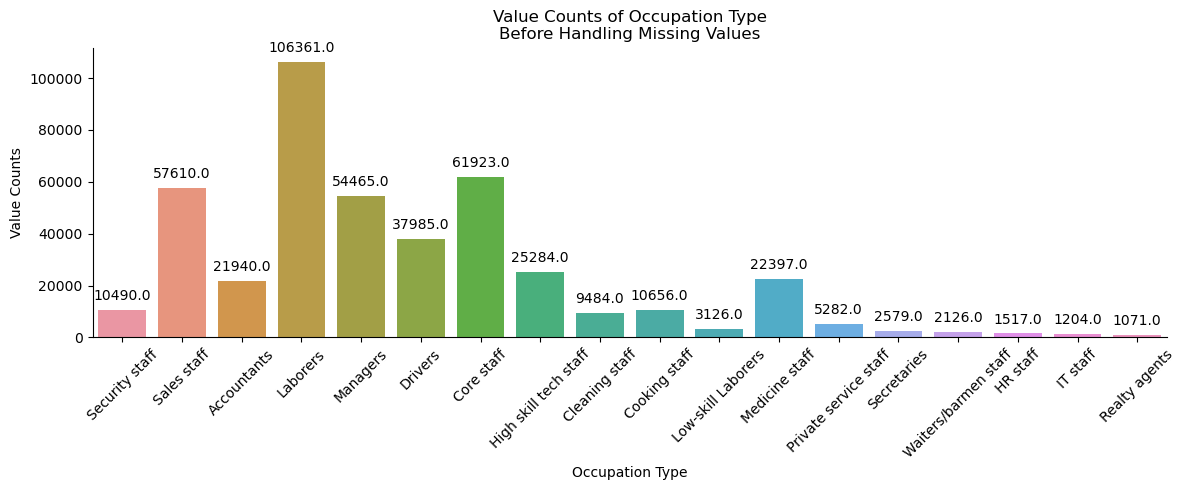

In [15]:
plt.figure(figsize=(12,5))
ax=sns.countplot(x='OCCUPATION_TYPE', data=data)

plt.title('Value Counts of Occupation Type\nBefore Handling Missing Values')
plt.xlabel('Occupation Type')
plt.ylabel('Value Counts')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks(rotation=45)
for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)

plt.show()

In [16]:
data.nunique()

OWN_CAR                2
OWN_REALTY             2
CNT_CHILDREN           9
AMT_INCOME_TOTAL     258
INCOME_TYPE            5
EDUCATION_TYPE         5
FAMILY_STATUS          5
HOUSING_TYPE           6
DAYS_BIRTH          6960
DAYS_EMPLOYED       3566
WORK_PHONE             2
PHONE                  2
EMAIL                  2
OCCUPATION_TYPE       18
CNT_FAM_MEMBERS       10
APPROVED_STATUS        2
dtype: int64

In [17]:
print('INCOME_TYPE : ',data.INCOME_TYPE.unique())
print('\nEDUCATION_TYPE : ',data.EDUCATION_TYPE.unique())
print('\nFAMILY_STATUS : ',data.FAMILY_STATUS.unique())
print('\nHOUSING_TYPE : ',data.HOUSING_TYPE.unique())

INCOME_TYPE :  ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

EDUCATION_TYPE :  ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

FAMILY_STATUS :  ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']

HOUSING_TYPE :  ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']


Before applying algorithm encoding needs to be done on categorical columns.
In place of classes in categorical columns values are manually replaced
instead of using label encoder

In [18]:
# encoding is done on object columns except OCCUPATION_TYPE column
# encoding can not be done on OCCUPATION_TYPE column without seperating null values from it 
# for loop is used to apply label encoding

#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#for col in data:
#    if data[col].dtype == object and col != "OCCUPATION_TYPE":
#        data[col]=le.fit_transform(data[col])

income_type = {
    'Working':0,
    'Commercial associate':1,
    'Pensioner':2,
    'State servant':3,
    'Student':4
}
education_type = {
    'Higher education':0,
    'Secondary / secondary special':1,
    'Incomplete higher':2,
    'Lower secondary':3,
    'Academic degree':4
}
family_status = {
    'Civil marriage':0,
    'Married':1,
    'Single / not married':2,
    'Separated':3,
    'Widow':4
}
housing_type = {
    'Rented apartment':0,
    'House / apartment':1,
    'Municipal apartment':2,
    'With parents':3,
    'Co-op apartment':4,
    'Office apartment':5
}

data['INCOME_TYPE'] = data['INCOME_TYPE'].replace(income_type)
data['EDUCATION_TYPE'] = data['EDUCATION_TYPE'].replace(education_type)
data['FAMILY_STATUS'] = data['FAMILY_STATUS'].replace(family_status)
data['HOUSING_TYPE'] = data['HOUSING_TYPE'].replace(housing_type)

In [19]:
# Extracted relevant columns for model training
train_data = data.dropna(subset=['OCCUPATION_TYPE'])
X_train = train_data.drop(columns=['OCCUPATION_TYPE'])
y_train = train_data['OCCUPATION_TYPE']

# Extracted data with null values for prediction
test_data = data[data['OCCUPATION_TYPE'].isnull()]
X_test = test_data.drop(columns=['OCCUPATION_TYPE'])

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Train a Decision Tree Classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train_encoded)

# Predict the missing values
predicted_occupation_encoded = classifier.predict(X_test)

# Decode the labels back to original values
predicted_occupation = le.inverse_transform(predicted_occupation_encoded)

# Filling the missing values in the original DataFrame
data.loc[data['OCCUPATION_TYPE'].isnull(), 'OCCUPATION_TYPE'] = predicted_occupation


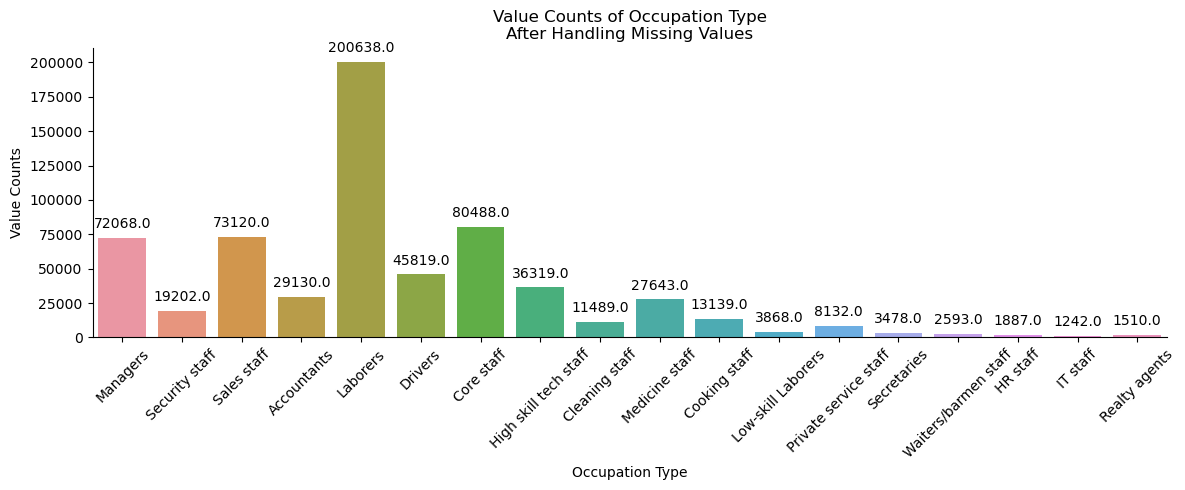

In [20]:
plt.figure(figsize=(12,5))
ax=sns.countplot(x='OCCUPATION_TYPE', data=data)
plt.title('Value Counts of Occupation Type\nAfter Handling Missing Values')
plt.xlabel('Occupation Type')
plt.ylabel('Value Counts')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks(rotation=45)
for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()

plt.show()


With the help of boxplot we can clearly see there is an outlier present in DAYS_EMPLOYED column.
There is only one value which repeated 104445 times i.e 17% of whole data, this value belongs to Income_type (Pensioner).
There is high chances that by droping this value whole data of class pensioner can be lost.
To solve this problem value is searched by using .unique() and .nlargest() and replaced by null,
null value is predicted by applying decision tree algorithm

In [21]:
# Both columns contains negative values to convert them into positive applied abs()
data['DAYS_BIRTH'] = data['DAYS_BIRTH'].abs() 
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].abs()

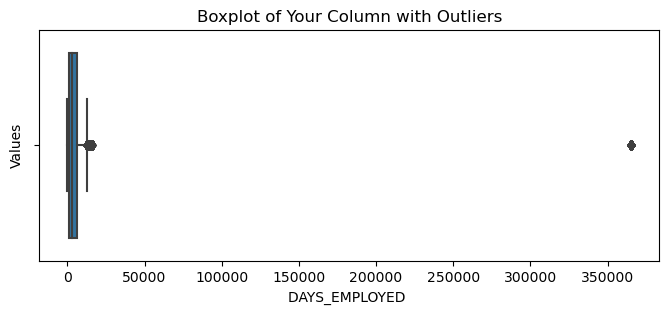

In [22]:
plt.figure(figsize=(8, 3))

# Create a boxplot
sns.boxplot(x=data['DAYS_EMPLOYED'])

# Identify outliers using the IQR method
Q1 = data['DAYS_EMPLOYED'].quantile(0.25)
Q3 = data['DAYS_EMPLOYED'].quantile(0.75)
IQR = Q3 - Q1
outliers = (data['DAYS_EMPLOYED'] < Q1 - 1.5 * IQR) | (data['DAYS_EMPLOYED'] > Q3 + 1.5 * IQR)

# Annotate outliers with their values
for index, value in data['DAYS_EMPLOYED'][outliers].items():
    plt.annotate(f"{value:.2f}", (index, value), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Boxplot of Your Column with Outliers')
plt.xlabel('DAYS_EMPLOYED ')
plt.ylabel('Values')
plt.show()

In [23]:
unique_val = data['DAYS_EMPLOYED'].unique()
unique_nlargest = pd.Series(unique_val).nlargest()
print(unique_nlargest)

3       365243
2974     15713
3493     15661
2563     15227
1301     15072
dtype: int64


In [24]:
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].replace(365243, pd.NA)

In [25]:
data.isnull().sum()

OWN_CAR                  0
OWN_REALTY               0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
INCOME_TYPE              0
EDUCATION_TYPE           0
FAMILY_STATUS            0
HOUSING_TYPE             0
DAYS_BIRTH               0
DAYS_EMPLOYED       104445
WORK_PHONE               0
PHONE                    0
EMAIL                    0
OCCUPATION_TYPE          0
CNT_FAM_MEMBERS          0
APPROVED_STATUS          0
dtype: int64

In [26]:
data.DAYS_EMPLOYED.dtype

dtype('O')

In [27]:
print('\nOCCUPATION_TYPE : ',data.OCCUPATION_TYPE.unique())


OCCUPATION_TYPE :  ['Managers' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Medicine staff' 'Cooking staff' 'Low-skill Laborers'
 'Private service staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'IT staff' 'Realty agents']


In [28]:
data.nunique()

OWN_CAR                2
OWN_REALTY             2
CNT_CHILDREN           9
AMT_INCOME_TOTAL     258
INCOME_TYPE            5
EDUCATION_TYPE         5
FAMILY_STATUS          5
HOUSING_TYPE           6
DAYS_BIRTH          6960
DAYS_EMPLOYED       3565
WORK_PHONE             2
PHONE                  2
EMAIL                  2
OCCUPATION_TYPE       18
CNT_FAM_MEMBERS       10
APPROVED_STATUS        2
dtype: int64

In [29]:
# in the last step this column was not encoded for visualization perpose

#le = LabelEncoder()
#data['OCCUPATION_TYPE']=le.fit_transform(data['OCCUPATION_TYPE'])

occupation_type = {
    'Managers':0,
    'Security staff':1,
    'Sales staff':2,
    'Accountants':3,
    'Laborers':4,
    'Drivers':5,
    'Core staff':6,
    'High skill tech staff':7,
    'Cleaning staff':8,
    'Cooking staff':9,
    'Medicine staff':10,
    'Low-skill Laborers':11,
    'Private service staff':12, 
    'Secretaries':13,
    'Waiters/barmen staff':14, 
    'HR staff':15,
    'IT staff':16, 
    'Realty agents':17
}
data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].replace(occupation_type)

In [30]:
# Extracted relevant columns for model training
train_data = data.dropna(subset=['DAYS_EMPLOYED'])
X_train = train_data.drop(columns=['DAYS_EMPLOYED'])
y_train = train_data['DAYS_EMPLOYED']

# Extracted data with null values for prediction
test_data = data[data['DAYS_EMPLOYED'].isnull()]
X_test = test_data.drop(columns=['DAYS_EMPLOYED'])

# Encode the target variable
le = LabelEncoder() 
y_train_encoded = le.fit_transform(y_train)

# Train a Decision Tree Classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train_encoded)

# Predict the missing values
predicted_DAYS_EMPLOYED = classifier.predict(X_test)

# Decode the labels back to original values
#predicted_occupation = le.inverse_transform(predicted_occupation_encoded)

# Filling the missing values in the original DataFrame
data.loc[data['DAYS_EMPLOYED'].isnull(), 'DAYS_EMPLOYED'] = predicted_DAYS_EMPLOYED

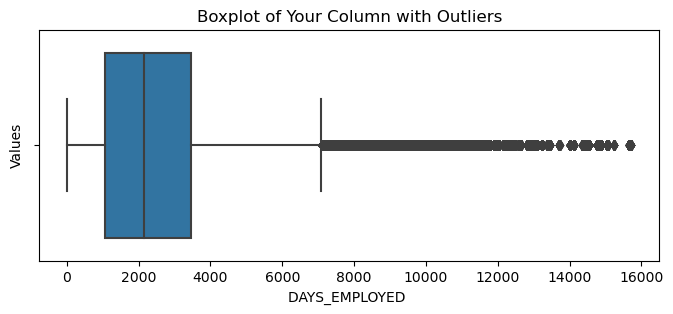

In [31]:
plt.figure(figsize=(8, 3))

# Create a boxplot
sns.boxplot(x=data['DAYS_EMPLOYED'])

# Identify outliers using the IQR method
Q1 = data['DAYS_EMPLOYED'].quantile(0.25)
Q3 = data['DAYS_EMPLOYED'].quantile(0.75)
IQR = Q3 - Q1
outliers = (data['DAYS_EMPLOYED'] < Q1 - 1.5 * IQR) | (data['DAYS_EMPLOYED'] > Q3 + 1.5 * IQR)

# Annotate outliers with their values
for index, value in data['DAYS_EMPLOYED'][outliers].items():
    plt.annotate(f"{value:.2f}", (index, value), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Boxplot of Your Column with Outliers')
plt.xlabel('DAYS_EMPLOYED ')
plt.ylabel('Values')
plt.show()

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631765 entries, 0 to 631764
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   OWN_CAR           631765 non-null  int64  
 1   OWN_REALTY        631765 non-null  int64  
 2   CNT_CHILDREN      631765 non-null  int64  
 3   AMT_INCOME_TOTAL  631765 non-null  float64
 4   INCOME_TYPE       631765 non-null  int64  
 5   EDUCATION_TYPE    631765 non-null  int64  
 6   FAMILY_STATUS     631765 non-null  int64  
 7   HOUSING_TYPE      631765 non-null  int64  
 8   DAYS_BIRTH        631765 non-null  int64  
 9   DAYS_EMPLOYED     631765 non-null  object 
 10  WORK_PHONE        631765 non-null  int64  
 11  PHONE             631765 non-null  int64  
 12  EMAIL             631765 non-null  int64  
 13  OCCUPATION_TYPE   631765 non-null  int64  
 14  CNT_FAM_MEMBERS   631765 non-null  int32  
 15  APPROVED_STATUS   631765 non-null  int64  
dtypes: float64(1), int32

In [33]:
# due to null values data type was changed to object need to change it again in int64
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].astype('int64')
data['DAYS_EMPLOYED'].dtypes

dtype('int64')

### Handling imbalance data using SMOTE

There is an imbalancement in classes of target columns, due to imbalancement it may affect models performance.
There is high chances that model can predict one class correctly and other class poorly.
Data contains more records of class 1 and much less records of class 0.
In that case over-sampling needs to be done, if under-sampling is performed huge data can be lost.
This problem can be solve using SMOTE (Synthetic Minority Over-sampling Technique).

In [34]:
from imblearn.over_sampling import SMOTE

train_data = data.drop('APPROVED_STATUS',axis=1)
test_data = data['APPROVED_STATUS']
print('Before Resampling \n')
print(f'shape of train_data : {train_data.shape}')
print(f'shape of test_data : {test_data.shape} \n')


smote = SMOTE(sampling_strategy='auto', random_state=42)
resampled_features, resampled_target = smote.fit_resample(train_data, test_data)

print('After Resampling \n')
print(f'shape of resampled_features : {resampled_features.shape}')
print(f'shape of resampled_target : {resampled_target.shape}')

Before Resampling 

shape of train_data : (631765, 15)
shape of test_data : (631765,) 

After Resampling 

shape of resampled_features : (1240380, 15)
shape of resampled_target : (1240380,)


Here we used barplot to differentiate between the data before and after handling imbalancement using SMOTE technique.

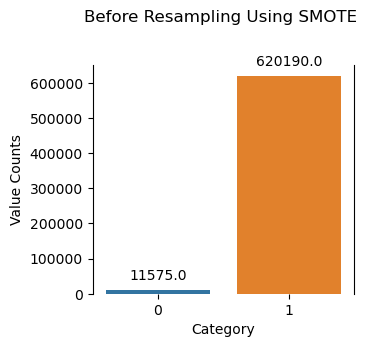

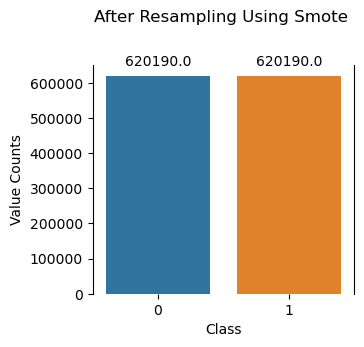

In [35]:
plt.figure(figsize=(4,3))
ax=sns.barplot(x=data['APPROVED_STATUS'].value_counts().index, y=data['APPROVED_STATUS'].value_counts())

plt.title('Before Resampling Using SMOTE \n\n')
plt.xlabel('Category')
plt.ylabel('Value Counts')
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout(pad = 2)
plt.subplots_adjust(hspace=0.6,top=1)
plt.show()

plt.figure(figsize=(4,3))
ax=sns.barplot(x = resampled_target.value_counts().index, y = resampled_target.value_counts())

plt.title('After Resampling Using Smote \n\n')
plt.xlabel('Class')
plt.ylabel('Value Counts')
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout(pad = 2)
plt.subplots_adjust(hspace=0.6,top=1)
plt.show()

### Base Models 
Trying different models and Hypertuning its parameter to finalize best model out of it.

###### 1st Model : Logistic Regression

Cross-Validation Mean Accuracy: 0.5615 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters: {'C': 0.001} 

Test Set Accuracy: 0.5646 

Confusion Matrix:
[[101128  84820]
 [ 77199 108967]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.56    185948
           1       0.56      0.59      0.57    186166

    accuracy                           0.56    372114
   macro avg       0.56      0.56      0.56    372114
weighted avg       0.56      0.56      0.56    372114



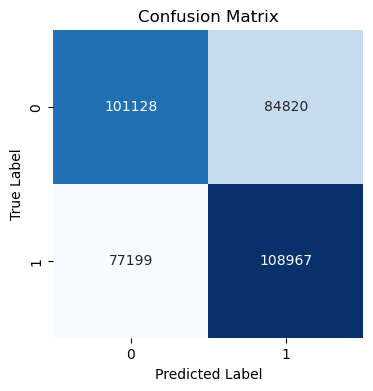

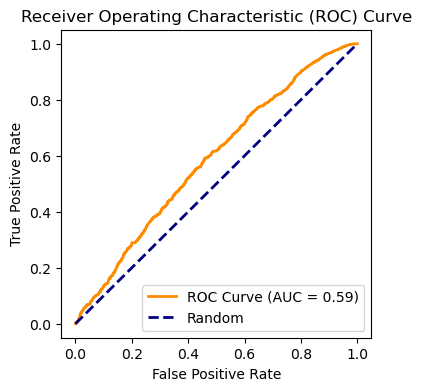

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(resampled_features, resampled_target, test_size=0.3, random_state=42)

# Standardizing the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating a logistic regression model
logreg_model = LogisticRegression(random_state=42)

# Performing cross-validation to evaluate the model
cv_scores = cross_val_score(logreg_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Mean Accuracy: {cv_scores.mean():.4f} \n')

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Example values for regularization parameter C
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters from the grid search
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params} \n')

# predictions on the test data using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f'Test Set Accuracy: {accuracy:.4f} \n')
print('Confusion Matrix:')
print(conf_matrix,'\n')
print('Classification Report:')
print(classification_report_str)

# Confusion Matrix Heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

###### 2nd Model : Decision Tree

Cross-Validation Mean Accuracy: 0.9081
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Test Set Accuracy: 0.9080 

Confusion Matrix:
[[176939   9009]
 [ 25216 160950]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91    185948
           1       0.95      0.86      0.90    186166

    accuracy                           0.91    372114
   macro avg       0.91      0.91      0.91    372114
weighted avg       0.91      0.91      0.91    372114



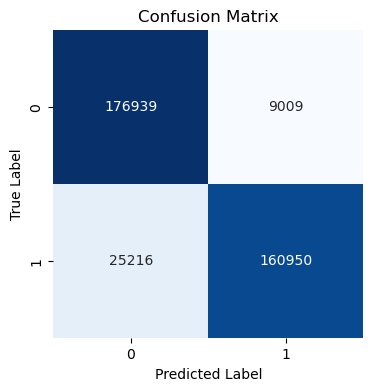

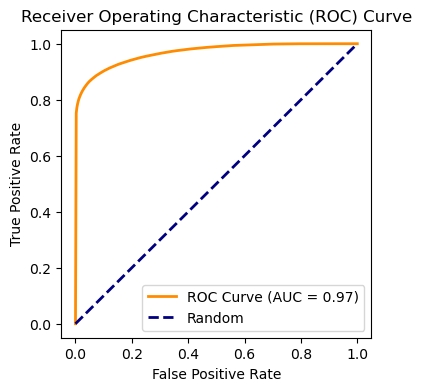

In [37]:

X_train, X_test, y_train, y_test = train_test_split(resampled_features, resampled_target, test_size=0.3, random_state=42)

# Standardizing the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)

# Performing cross-validation to evaluate the model
cv_scores = cross_val_score(tree_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}')

# Hyperparameter tuning using GridSearchCV
param_grid = {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters from the grid search
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Predictions on the test data using the best model
best_tree_model = grid_search.best_estimator_
y_pred = best_tree_model.predict(X_test_scaled)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f'Test Set Accuracy: {accuracy:.4f} \n')
print('Confusion Matrix:')
print(conf_matrix,'\n')
print('Classification Report:')
print(classification_report_str)

# Confusion Matrix Heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_tree_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

###### 3rd Model : Random Forest Classifier

###### 4th Model  :  SVM

### Final Model

###### Decision Tree

Cross-Validation Mean Accuracy: 0.9081
Test Set Accuracy: 0.9080 

Confusion Matrix:
[[176932   9016]
 [ 25212 160954]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91    185948
           1       0.95      0.86      0.90    186166

    accuracy                           0.91    372114
   macro avg       0.91      0.91      0.91    372114
weighted avg       0.91      0.91      0.91    372114



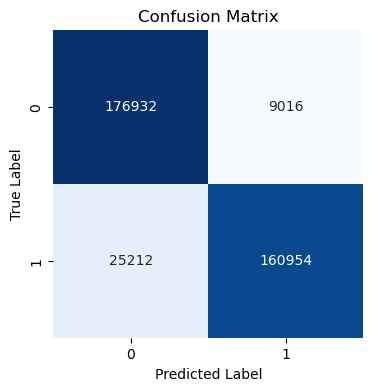

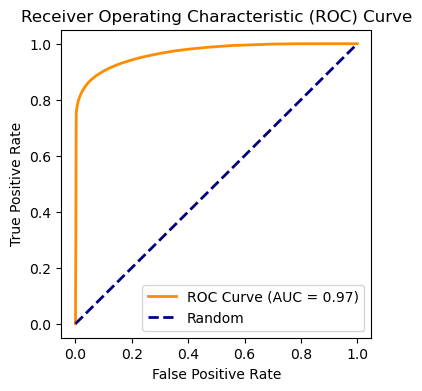

In [38]:

X_train, X_test, y_train, y_test = train_test_split(resampled_features, resampled_target, test_size=0.3, random_state=42)

# Standardizing the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating Decision Tree model with finalized parameters
best_parameters = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state':42}
final_tree_model = DecisionTreeClassifier(**best_parameters)

# Performing cross-validation to evaluate the model
cv_scores = cross_val_score(final_tree_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}')

final_tree_model.fit(X_train_scaled,y_train)

# Predictions on the test data using the final model
final_y_pred = final_tree_model.predict(X_test_scaled)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, final_y_pred)
conf_matrix = confusion_matrix(y_test, final_y_pred)
final_classification_report = classification_report(y_test, final_y_pred)

# Print the results
print(f'Test Set Accuracy: {accuracy:.4f} \n')
print('Confusion Matrix:')
print(conf_matrix,'\n')
print('Classification Report:')
print(final_classification_report)

# Confusion Matrix Heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, final_tree_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Difining function for final model

In [39]:
def final_model(selected_model,selected_param):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    param = selected_param
    model = selected_model(**param)
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f'Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}')
    
    model.fit(X_train_scaled,y_train)
    final_y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, final_y_pred)
    conf_matrix = confusion_matrix(y_test, final_y_pred)
    final_classification_report = classification_report(y_test, final_y_pred)
    
    print(f'Test Set Accuracy: {accuracy:.4f} \n')
    print('Confusion Matrix:')
    print(conf_matrix,'\n')
    print('Classification Report:')
    print(final_classification_report)
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    with open('scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
    
    with open('model.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)
    

Cross-Validation Mean Accuracy: 0.9081
Test Set Accuracy: 0.9080 

Confusion Matrix:
[[176932   9016]
 [ 25212 160954]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91    185948
           1       0.95      0.86      0.90    186166

    accuracy                           0.91    372114
   macro avg       0.91      0.91      0.91    372114
weighted avg       0.91      0.91      0.91    372114



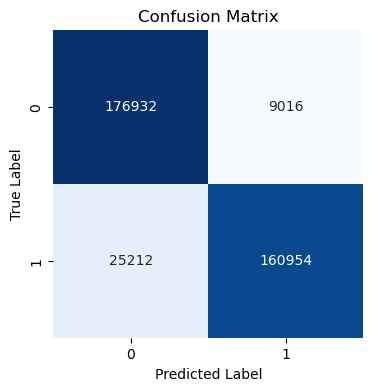

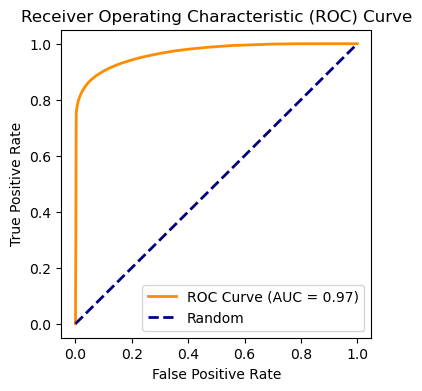

In [40]:
selected_model = DecisionTreeClassifier
selected_param = {
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'random_state':42
}

final_model(selected_model,selected_param)